In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PolynomialFeatures, SplineTransformer, KBinsDiscretizer, \
     StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression, r_regression, mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score, get_scorer_names, accuracy_score, f1_score, precision_score, \
     confusion_matrix, recall_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV, KFold, train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor, LocalOutlierFactor
import sklearn.linear_model as lm
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

# from imblearn.under_sampling import NearMiss, CondensedNearestNeighbour
# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline as imbPipeline
# from imblearn.combine import SMOTETomek
# from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier
# from imblearn.metrics import classification_report_imbalanced
# import lightgbm as lgb

import os
import pickle
import wandb
import warnings
import utility as ut
warnings.filterwarnings('ignore')

In [49]:
run = wandb.init(
  project=ut.PROJECT_NAME, entity=ut.ENTITY, job_type="modeling",
  notes="Modeling using lightgbm with undersampling",
  tags=["baseline", "multiclass_classification", "ligtgbm", "undersampling"]
)

In [50]:
train = pd.read_csv('../Inputs/ball-by-ball prediction/train.csv')

In [51]:
def safe_div(x,y):
    if y == 0:
        return x
    return x.div(y, axis=0)

def get_train_test_split(df, target = 'target', test_size=0.1):
    le = LabelEncoder()
    X, y = df.drop(target, axis=1), le.fit_transform(df[target])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=420)
    return X_train, X_test, y_train, y_test

In [52]:
class CustomFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Batting features
        X['bat_runs_scored'] = 1*X['bat_1_runs']+2*X['bat_2_runs']+3*X['bat_3_runs']+4*X['bat_4_runs']+6*X['bat_6_runs']
        # X['bat_strike_rate'] = safe_div(X['bat_runs_scored'], X['bat_total_balls'])*100
        # X['bat_avg'] = safe_div(X['bat_runs_scored'], X['bat_num_dismissals'])

        # Bowling features
        X['bowl_runs_conceded'] = 1*X['bowl_1_runs']+2*X['bowl_2_runs']+3*X['bowl_3_runs']+4*X['bowl_4_runs']+6*X['bowl_6_runs']
        # X['bowl_average'] = safe_div(X['bowl_runs_conceded'], X['bowl_total_balls'])
        # X['bowl_strike_rate'] = safe_div(X['bowl_total_balls'], X['bowl_num_dismissals'])
        # Other features
        # ... (include any other feature engineering steps here)

        return X

In [53]:
minitrain = train.copy()

In [54]:
le = LabelEncoder()
X, y = train.drop('target', axis=1), le.fit_transform(train['target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=420)

In [55]:
cat_features = X.select_dtypes(include=['object']).columns
num_features = X.drop(columns='innings').select_dtypes(exclude=['object']).columns

In [56]:
numeric_transformer = Pipeline([
      # ('poly_feats', PolynomialFeatures(degree=2)),
      # ('log_feats', LogTransformer()),
      # ('b_splines', SplineTransformer()),
      ('scaler', StandardScaler()),
      # ('bin', KBinsDiscretizer(encode='ordinal')), #only improved Lars
      # ('select_feats', SelectKBest(f_regression, k='all'))
])
categorical_transformer = Pipeline([
      ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])

In [57]:
preprocessor = ColumnTransformer(
    transformers=[
        # ('new_feats', CustomFeatureTransformer(), num_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), ['innings']),
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

In [58]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [62]:
# define the undersampling method
# undersample = CondensedNearestNeighbour(n_neighbors=10)
# transform the dataset
# X_us, y_us = undersample.fit_resample(X_train, y_train)

wandb: Network error (ConnectTimeout), entering retry loop.


In [35]:
classifier = lgb.LGBMClassifier()

In [36]:
classifier.fit(X_us, y_us)

LGBMClassifier()

In [38]:
predictions = classifier.predict(preprocessor.transform(X_test))

In [33]:
# cw = {}
# classifier = SVC(kernel='rbf', class_weight='balanced', random_state=3142)
# classifier = RandomForestClassifier(n_estimators=200, max_depth=15, class_weight='balanced', n_jobs=-1, random_state=3142)
# pipeline = Pipeline(steps = [
#     ('preprocessor', preprocessor),
#     # ('undersample', undersample),
#     ('classifier',classifier)
# ])

In [99]:
model.score(X_train, y_train)

0.5519834630976128

In [100]:
predictions = model.predict(X_test)

In [101]:
wandb.summary['accuracy_test'] = accuracy_score(y_test, predictions)
wandb.summary['f1_score_test'] = f1_score(y_test, predictions, average='weighted')
wandb.summary['precision_test'] = precision_score(y_test, predictions, average='weighted')
wandb.summary['recall_test'] = recall_score(y_test, predictions, average='weighted')

In [102]:
train_preds = model.predict(X_train)

In [103]:
wandb.summary['accuracy_train'] = accuracy_score(y_train, train_preds)
wandb.summary['f1_score_train'] = f1_score(y_train, train_preds, average='weighted')
wandb.summary['precision_train'] = precision_score(y_train, train_preds, average='weighted')
wandb.summary['recall_train'] = recall_score(y_train, train_preds, average='weighted')

In [43]:
labels = le.classes_
labels

array(['0_runs', '1_runs', '2_runs', '3_runs', '4_runs', '6_runs',
       'Wicket'], dtype=object)

In [47]:
# Visualize single plot
wandb.sklearn.plot_confusion_matrix(y_test, predictions, labels)
wandb.sklearn.plot_roc(y_test, classifier.predict_proba(preprocessor.transform(X_test)), labels)
wandb.sklearn.plot_precision_recall(y_test, classifier.predict_proba(preprocessor.transform(X_test)), labels)
wandb.sklearn.plot_class_proportions(y_train, y_test, labels)
# wandb.sklearn.plot_feature_importances(model.named_steps['classifier'], X_train.columns, max_num_features=10)

wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.


In [48]:
wandb.finish()

accuracy_test,0.06602
f1_score_test,0.07286
precision_test,0.33708
recall_test,0.06602


In [40]:
cm = confusion_matrix(y_test, predictions)

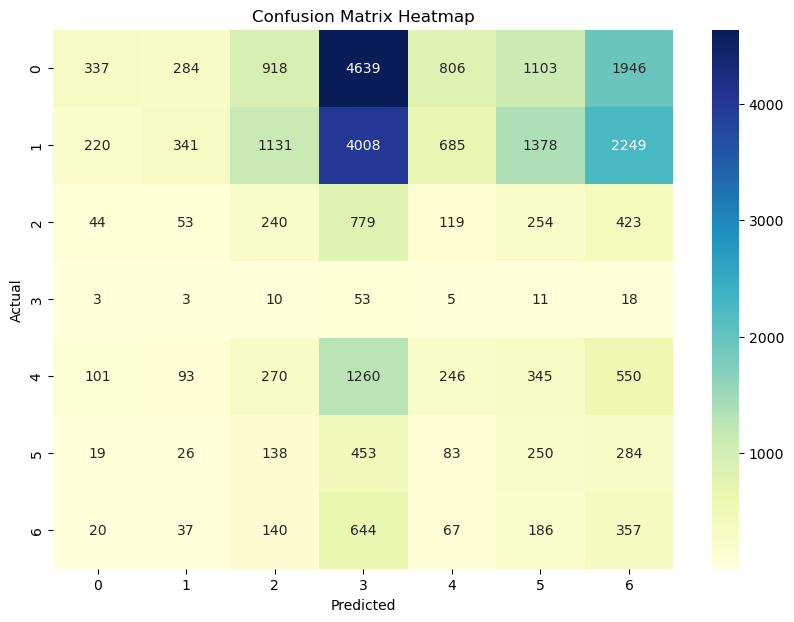

In [41]:
# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [ ]:
pd.DataFrame(y_test).value_counts()

0    10033
1    10012
4     2865
2     1912
6     1451
5     1253
3      103
dtype: int64

In [ ]:
pd.DataFrame(predictions).value_counts()

0    12134
1     8463
4     3032
2     2036
5     1312
6      597
3       55
dtype: int64

In [ ]:
print(f'----{type(classifier).__name__}-----')
print (f'Model f1 score (macro):{f1_score(predictions, y_test, average="macro")}')
print (f'Model f1 score (micro):{f1_score(predictions, y_test, average="micro")}')
print (f'Model f1 score (weighted):{f1_score(predictions, y_test, average="weighted")}')
# print (f'Model acc:{accuracy_score(predictions, y_test)}')

----LogisticRegressionCV-----
Model f1 score (macro):0.1674036246848558
Model f1 score (micro):0.3377972420283036
Model f1 score (weighted):0.3438043124369311
